In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import scipy
%matplotlib inline

In [2]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))

    return s

In [3]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.ones((dim,1))
    b = 0.

    return w, b

In [4]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """
    m = X.shape[1]
    #print('number of objects = ',len(X))

    # FORWARD PROPAGATION (FROM X TO COST)
    eps = 1e-15
    A = sigmoid(np.dot(w.T,X)+b)                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A+eps)+(1-Y)*np.log(1-A+eps),axis=1)   # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = float((1./m)*np.sum(A-Y))# (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [5]:
# optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False, optimizer="gd",
             beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """
    
    costs = []

    m = X.shape[1]

    v_dw = np.zeros_like(w)
    v_db = 0.
    s_dw = np.zeros_like(w)
    s_db = 0.
    t = 0

    for i in range(num_iterations):

        if optimizer == "sgd":
            idx = np.random.randint(0, m)
            X_batch = X[:, idx:idx+1]
            Y_batch = Y[:, idx:idx+1] #Y[0][idx:idx+1]; Y[:, idx:idx+1]
            grads, _ = propagate(w, b, X_batch, Y_batch)
            _, cost = propagate(w, b, X, Y)

        else:
            grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        if optimizer == "gd":
            w -= learning_rate * dw
            b -= learning_rate * db

        elif optimizer == "sgd":
            w -= learning_rate * dw
            b -= learning_rate * db

        elif optimizer == "adam":
            t += 1

            v_dw = beta1 * v_dw + (1 - beta1) * dw
            v_db = beta1 * v_db + (1 - beta1) * db

            v_dw_corr = v_dw / (1 - beta1 ** t)
            v_db_corr = v_db / (1 - beta1 ** t)

            s_dw = beta2 * s_dw + (1 - beta2) * (dw ** 2)
            s_db = beta2 * s_db + (1 - beta2) * (db ** 2)

            s_dw_corr = s_dw / (1 - beta2 ** t)
            s_db_corr = s_db / (1 - beta2 ** t)

            w -= learning_rate * v_dw_corr / (np.sqrt(s_dw_corr) + epsilon)
            b -= learning_rate * v_db_corr / (np.sqrt(s_db_corr) + epsilon)

        # if i % 100 == 0:
        #     _, full_cost = propagate(w, b, X, Y)
        #     costs.append(full_cost)

        costs.append(cost)
        if i % 100 == 0 and print_cost:
            print (f"Cost after iteration {i}: {round(cost[0], 7)}")

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [6]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities
    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1

    return Y_prediction

In [7]:
# model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5,
          print_cost = False, print_accuracy = False, optimizer="gd"):
     """
    Builds the logistic regression model by calling the function we've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """
     w, b = initialize_with_zeros(X_train.shape[0])

     parameters, grads, costs = optimize(
          w, b, X_train, Y_train,
          num_iterations,
          learning_rate,
          print_cost,
          optimizer=optimizer
     )

     w = parameters["w"]
     b = parameters["b"]

     Y_prediction_test = predict(w, b, X_test)
     Y_prediction_train = predict(w, b, X_train)

     train_accuracy = 100 - np.mean(np.abs(Y_prediction_train - Y_train) * 100)
     test_accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test) * 100)

     if print_accuracy:
          print(f"train accuracy: {train_accuracy}")
          print(f"test accuracy: {test_accuracy}")

     d = {
          "costs": costs,
          "Y_prediction_test": Y_prediction_test,
          "Y_prediction_train" : Y_prediction_train,
          "w" : w,
          "b" : b,
          "learning_rate" : learning_rate,
          "num_iterations": num_iterations,
          "train_accuracy": train_accuracy,
          "test_accuracy": test_accuracy
     }

     return d

In [8]:
df = pd.read_csv('bioresponse.csv')
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [9]:
target = 'Activity'
features = [column for column in df.columns if column != target]

X = df[features]
y = df[target]

In [10]:
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, y, test_size=0.25, stratify=y)

train_set_x = train_set_x.to_numpy().T
test_set_x  = test_set_x.to_numpy().T
train_set_y = train_set_y.to_numpy().reshape(1, -1)
test_set_y  = test_set_y.to_numpy().reshape(1, -1)

### Different Optimizers Comparasion With Fixed Params
- iterations number = 1000
- learning rate = 0.1

In [11]:
num_iters = 1000
learning_rate = 0.1
optimizers = ['gd', 'sgd', 'adam']

In [12]:
results_dict = {
    optimizer: {
        'costs': [],
        'train_accuracy': [],
        'test_accuracy': []
    } for optimizer in optimizers
}

for optimizer in optimizers:
        d = model(
            train_set_x, train_set_y, test_set_x, test_set_y, 
            num_iterations=num_iters, 
            learning_rate=learning_rate, 
            optimizer=optimizer
        )
        results_dict[optimizer]['costs'].append(d['costs'])
        results_dict[optimizer]['train_accuracy'].append(d['train_accuracy'])
        results_dict[optimizer]['test_accuracy'].append(d['test_accuracy'])

In [13]:
results_df = pd.DataFrame(columns=['optimizer', 'learning rate', 'train accuracy', 'test accuracy'])

for optimizer in optimizers:
    results_df.loc[len(results_df)] = [
        optimizer.upper(), learning_rate, results_dict[optimizer]['train_accuracy'][0], results_dict[optimizer]['test_accuracy'][0]
    ]

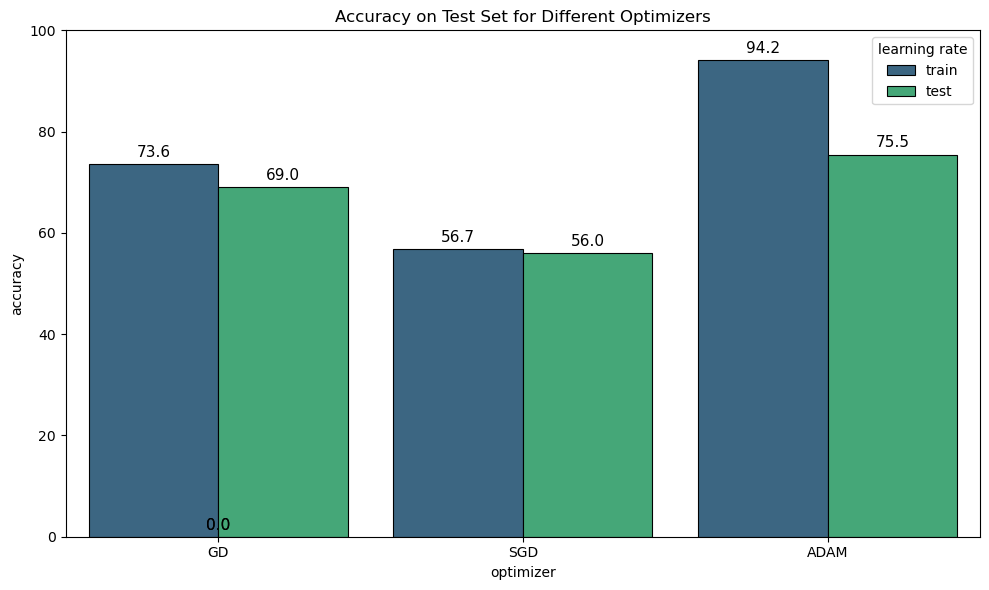

In [14]:
# accuracy comparasion
vis_df = results_df.copy()

melted = vis_df.melt(
    id_vars=["optimizer", "learning rate"],
    value_vars=["train accuracy", "test accuracy"],
    var_name="metric",
    value_name="accuracy"
)

melted["metric"] = melted["metric"].str.replace(" accuracy", "")

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=melted,
    x="optimizer",
    y="accuracy",
    hue="metric",
    palette="viridis",
    edgecolor="black",
    linewidth=0.8,
    width=0.85
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.1f}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=11,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.title("Accuracy on Test Set for Different Optimizers", size=12)
plt.legend(title="learning rate")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

**The model with the adam optimizer achieved the best result according to the accuracy metric.**

At the same time, it shows a strong gap between train and test accuracy, which may indicate that the model has been retrained, but manual early stopping (at 200-300 iterations) showed that accuracy on the test dataset is not improving.

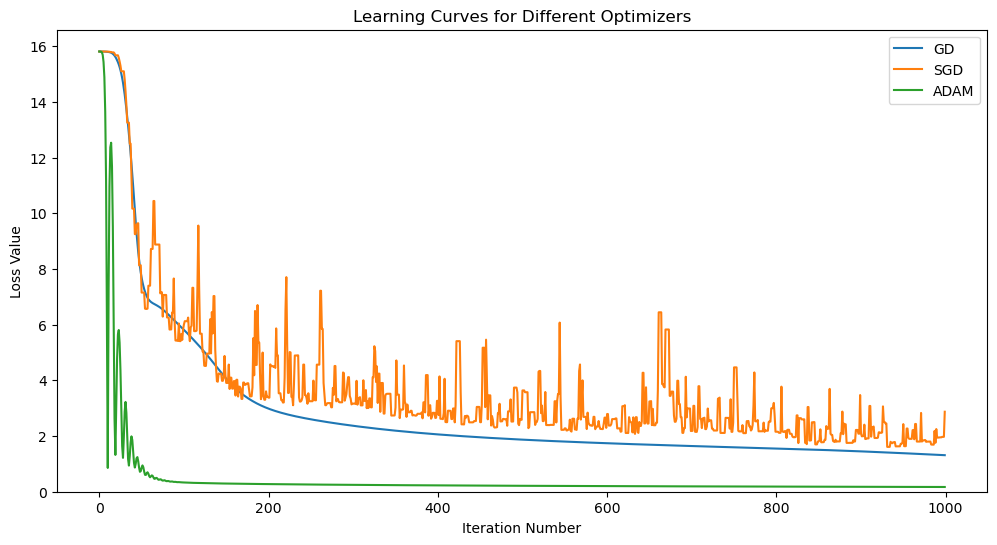

In [15]:
plt.figure(figsize=(12,6))

for i, optimizer in enumerate(optimizers):
    costs = results_dict[optimizer]['costs'][0]
    plt.plot(costs, label=f'{optimizer.upper()}')

plt.ylim(bottom=0)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.title(f'Learning Curves for Different Optimizers')
plt.legend()
plt.show()

**All models converge to some local value of the loss function, but the Adam optimizer helps to achieve the lowest value (and faster)**

### Different Learning Rates

In [16]:
num_iters = 1000
learning_rates = [0.005, 0.01, 0.05, 0.1, 0.2]
optimizers = ['gd', 'sgd', 'adam']

In [17]:
results_dict = {
    optimizer: {
        'costs': [],
        'train_accuracy': [],
        'test_accuracy': []
    } for optimizer in optimizers
}

for learning_rate in learning_rates:
    for optimizer in optimizers:
        d = model(
            train_set_x, train_set_y,
            test_set_x, test_set_y, 
            num_iterations=num_iters, 
            learning_rate=learning_rate, 
            print_cost=False,
            print_accuracy=False,
            optimizer=optimizer
        )
        results_dict[optimizer]['costs'].append(d['costs'])
        results_dict[optimizer]['train_accuracy'].append(d['train_accuracy'])
        results_dict[optimizer]['test_accuracy'].append(d['test_accuracy'])

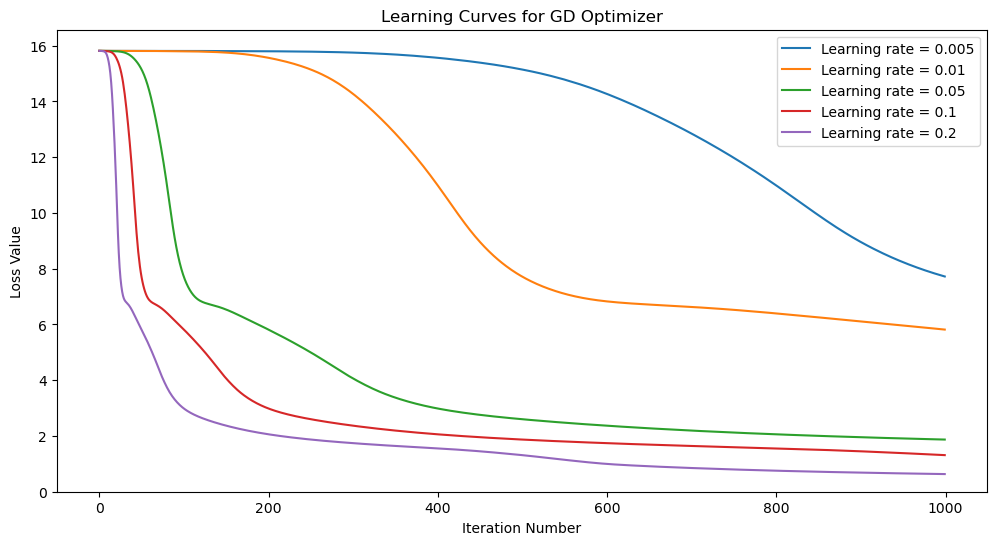

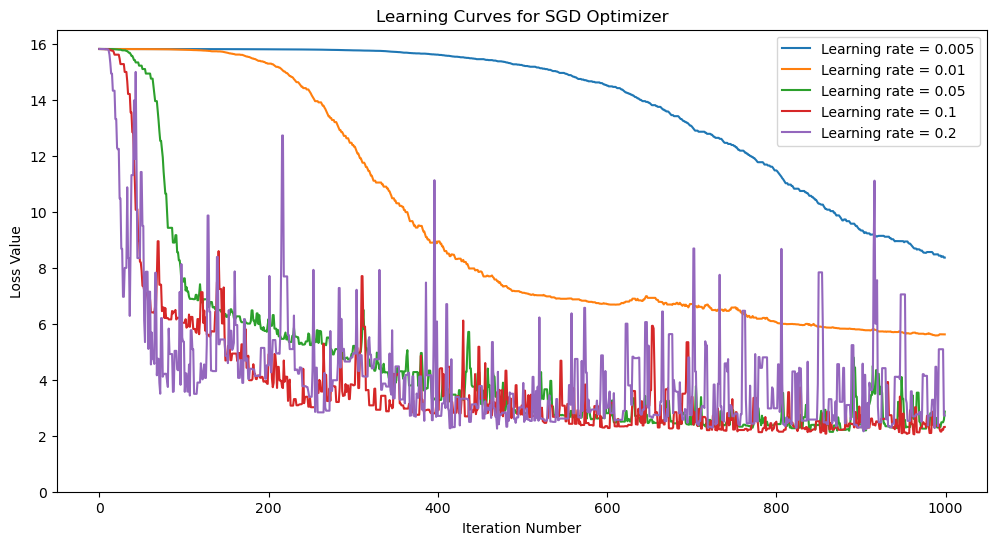

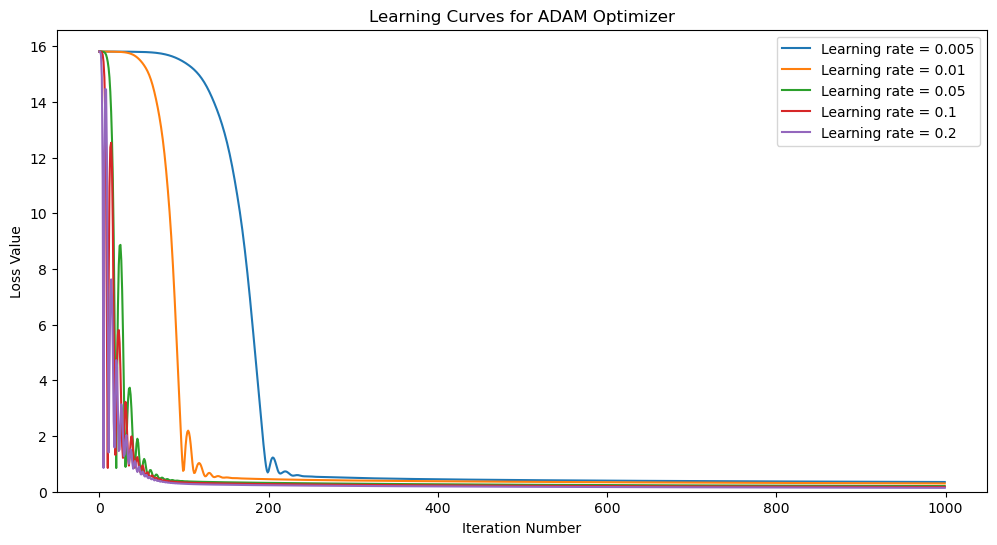

In [18]:
for optimizer in optimizers:
    plt.figure(figsize=(12,6))

    for i, learning_rate in enumerate(learning_rates):
        costs = results_dict[optimizer]['costs'][i]
        plt.plot(costs, label=f'Learning rate = {learning_rate}')
    
    plt.ylim(bottom=0)
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss Value')
    plt.title(f'Learning Curves for {optimizer.upper()} Optimizer')
    plt.legend()
    plt.show()

In [19]:
results_df = pd.DataFrame(columns=['optimizer', 'learning rate', 'train accuracy', 'test accuracy'])

for optimizer in optimizers:
    for i, learning_rate in enumerate(learning_rates):
        results_df.loc[len(results_df)] = [
            optimizer.upper(), learning_rate, results_dict[optimizer]['train_accuracy'][i], results_dict[optimizer]['test_accuracy'][i]
        ]

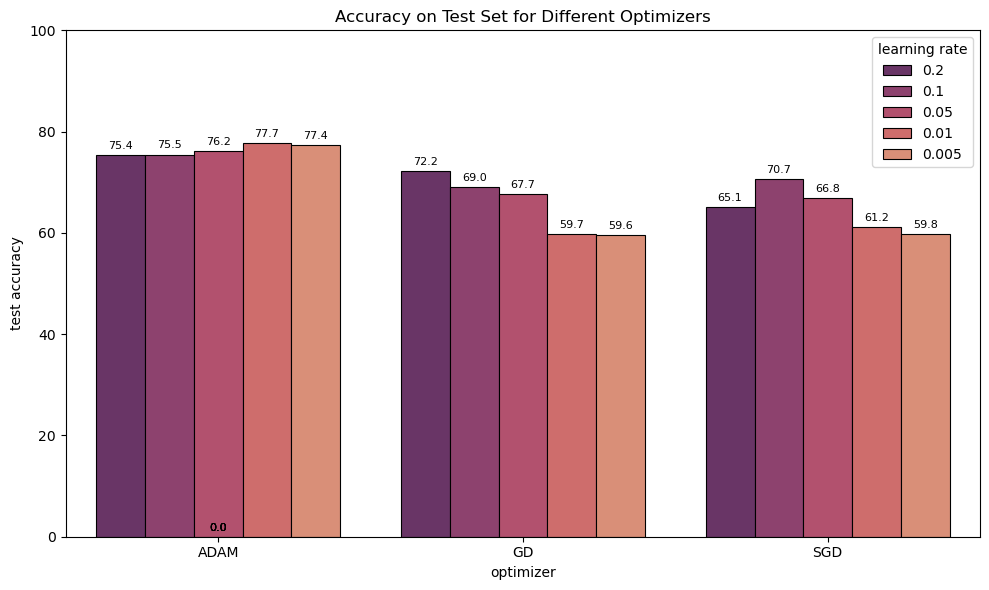

In [20]:
vis_df = results_df.copy()
vis_df = vis_df.sort_values(["optimizer", "learning rate"], ascending=[True, False])

plt.figure(figsize=(10, 6))

unique_lrs = sorted(vis_df["learning rate"].unique(), reverse=True)
palette = sns.color_palette("flare_r", len(unique_lrs))

ax = sns.barplot(
    data=vis_df,
    x="optimizer",
    y="test accuracy",
    hue="learning rate",
    hue_order=unique_lrs,
    palette=palette,
    edgecolor="black", 
    linewidth=0.8,
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.1f}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=8,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.title("Accuracy on Test Set for Different Optimizers")
plt.legend(title="learning rate")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

- **GD & SGD allows to achieve the highest accuracy on test data at the highest learning rate (0.2)**  
Otherwise, they get stuck in a local minimum.

- **However, Adam is step-sensitive and needs a lower learning rate.**  
Highest accuracy on test data achieved with lowest learning rate (0.005)